# tSNE

In [1]:
import os
from sklearn import manifold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
path = str(Path(os.getcwd()).parent.parent)
sys.path.insert(0, path)
from breakout.vae.vae import ConvVAE

import_path = str(Path(os.getcwd()).parent.parent.parent)

sys.path.insert(0, import_path)

from WorldModelsExperiments.breakout.model import make_model, _process_frame

In [8]:
num_actions = 4
    
gamename ='breakout'
optimizer = 'cma'
num_episode = 16
population = 64 # = num_workers * num_worker_trial
    
path = '/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200423'
    
file_path = path + '/log/'
file_base = gamename+'.'+optimizer+'.'+str(num_episode)+'.'+str(population)
    
vae_path = path + '/tf_vae'
rnn_path = path + '/tf_rnn'
    
record = path + '/record_noframeskip'

In [9]:
model = make_model(rnn_path=os.path.join(rnn_path, 'rnn.json'), vae_path=os.path.join(vae_path, 'vae.json'))

model.load_model(os.path.join(file_path, file_base + '.best.json'))

INFO:tensorflow:Model using cpu.
loading file /home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200423/log/breakout.cma.16.64.best.json


In [5]:
# run simulate several times to collect data

In [6]:
def simulate(model, train_mode=False, render_mode=True, num_episode=5, seed=-1, max_len=-1):
    reward_list = []
    t_list = []
    max_episode_length = 2100
    tsne_data = pd.DataFrame()    
    action_list = []#action_list_episode = []
    observation_list_episode = []
    reward_target = []
    
    if (seed >= 0):
        random.seed(seed)
        np.random.seed(seed)
        model.env.seed(seed)
    

    for episode in range(num_episode):
        #action_list = []
        observation_list = []
        obs = model.env.reset()
        if obs is None:
            obs = deepcopy(model.env.reset())
        #obs = _process_frame(obs)

        total_reward = 0.0

        for t in range(max_episode_length):
            if render_mode:
                model.env.render("human")
                model.env.unwrapped.viewer.window.on_key_press = key_press
                if RENDER_DELAY:
                    time.sleep(0.01)
            else:
                model.env.render('rgb_array')
            obs = _process_frame(obs)
            z, mu, logvar = model.encode_obs(obs)
            _, action = model.get_action(z)
            obs, reward, done, info = model.env.step(action)

            action_list.append(int(action))
            #observation_list.append(obs)
            #obs = _process_frame(obs)
            total_reward += reward
            reward_target.append(int(reward))
            
            data = np.concatenate([z, model.state.h[0]]).reshape(1,288)
            #data = np.append(data, action).reshape(1,289)
            tsne_data = tsne_data.append(pd.DataFrame(data), ignore_index=True)

            if done:
                if render_mode:
                    model.env.close()
                #action_list_episode.append(np.array(action_list))
                #observation_list_episode.append(observation_list)
                break
        if render_mode:
            print("reward", total_reward, "timesteps", t)
        #reward_list.append(total_reward)
        #t_list.append(t)
    return action_list, tsne_data, reward_target


In [10]:
actions, tsne_data, reward_target= simulate(model, train_mode=False, render_mode=False, num_episode=100)

In [11]:
tsne_data.shape

(35148, 288)

## TSNE - Target: Actions

In [12]:
actions = np.array(actions)

In [ ]:
actions

In [13]:
actions.shape

(35148,)

In [14]:
tsne = manifold.TSNE(n_components= 2, init='random', random_state=0)

In [15]:
y_tsne = tsne.fit_transform(tsne_data)

In [16]:
y_tsne.shape

(35148, 2)

In [15]:
y_tsne

array([[  7.4727, -31.5705],
       [  7.4112, -31.6035],
       [  7.4265, -31.6149],
       [  7.3811, -31.6294],
       [  7.304 , -32.6916],
       [  6.5295, -32.8925],
       ...,
       [-26.9774, -28.2901],
       [-27.0095, -25.665 ],
       [-23.0703, -28.2594],
       [-27.7415, -28.6797],
       [-24.211 , -24.3944],
       [-24.81  , -27.8279]], dtype=float32)

In [16]:
y_tsne_1, y_tsne_2 = np.array_split(y_tsne, indices_or_sections=2, axis=1)

In [1]:
y_tsne_1.shape

NameError: name 'y_tsne_1' is not defined

In [18]:
# https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_tsne.html

In [17]:
cut = 1.01
xmax = cut * max(y_tsne[:,0])
ymax = cut * max(y_tsne[:,1])
xmin = cut * min(y_tsne[:,0])
ymin = cut * min(y_tsne[:,1])

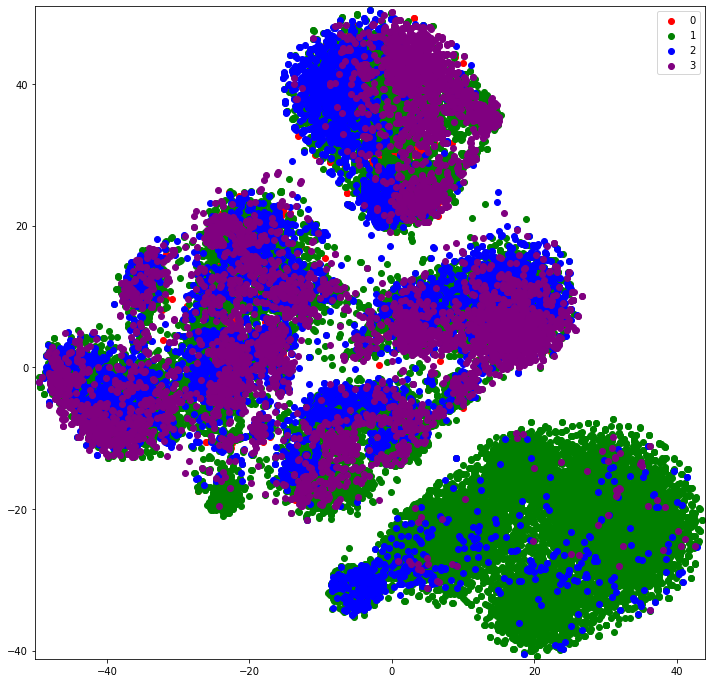

In [18]:
colors = 'r', 'g', 'b', 'purple'
target_ids = range(4)


plt.figure(figsize=(12,12))
for i, c in zip(target_ids, colors):
    plt.scatter(y_tsne[actions==i, 0], y_tsne[actions==i, 1], c=c, label =i)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

In [ ]:
perplexities = [5, 30, 50, 100]
(fig, subplots) = plt.subplots(1,4, figsize=(24,6))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perplexity)
    Y_tsne = tsne.fit_transform(tsne_data)
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(y_tsne[actions==0,0], y_tsne[actions==0,1], c='r', label=0)
    ax.scatter(y_tsne[actions==1,0], y_tsne[actions==1,1], c='g', label=1)
    ax.scatter(y_tsne[actions==2,0], y_tsne[actions==2,1], c='b', label=2)
    ax.scatter(y_tsne[actions==3,0], y_tsne[actions==3,1], c='purple', label=3)
plt.legend()
plt.show()

### Analysis of cluster and frames within cluster

#### grünes cluster unten rechts

In [32]:
clu1 = np.where((y_tsne[:,0]>22) & (y_tsne[:,0]<23) & (y_tsne[:,1]<-23) & (y_tsne[:,1]>-24))[0].tolist()
len(clu1)

46

In [33]:
clu1_green = [elem for elem in clu1 if actions[elem]==1]
len(clu1_green)

44

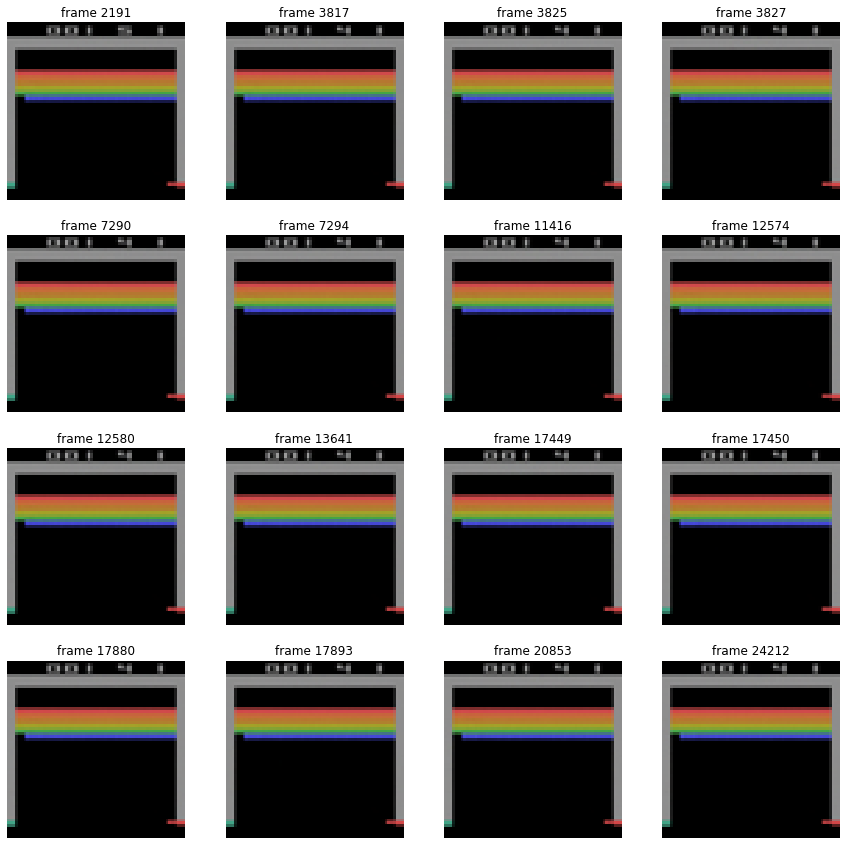

In [34]:
plt.figure(figsize=(15,15)) 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.title(f"frame {clu1_green[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu1_green[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')
    

grünes cluster mitte rechts

In [35]:
clu2 = np.where((y_tsne[:,0]>27) & (y_tsne[:,0]<28) & (y_tsne[:,1]<-1) & (y_tsne[:,1]>-2))[0].tolist()
len(clu2)

48

In [47]:
clu2_green = [elem for elem in clu2 if actions[elem]==1]
len(clu2_green)

48

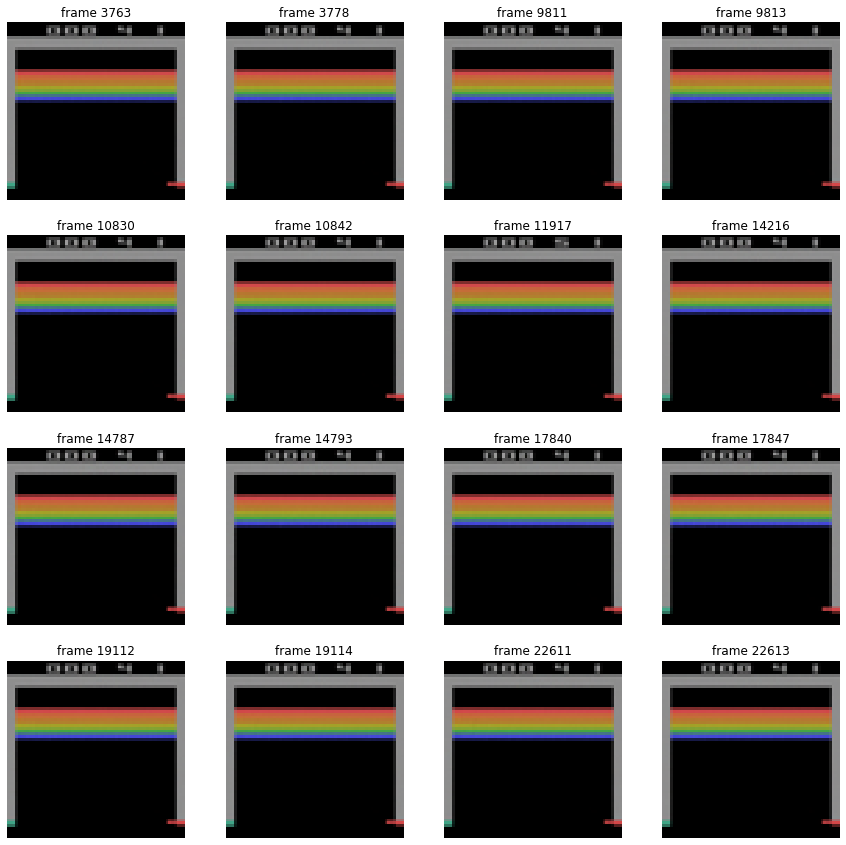

In [48]:
plt.figure(figsize=(15,15)) 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.title(f"frame {clu2_green[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu2_green[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')
    

blau rechts (im grünen cluster)

In [45]:
clu3 = np.where((y_tsne[:,0]>9) & (y_tsne[:,0]<11) & (y_tsne[:,1]<-3) & (y_tsne[:,1]>-6))[0].tolist()
len(clu3)

167

In [49]:
clu3_blue = [elem for elem in clu3 if actions[elem]==2]
len(clu3_blue)

68

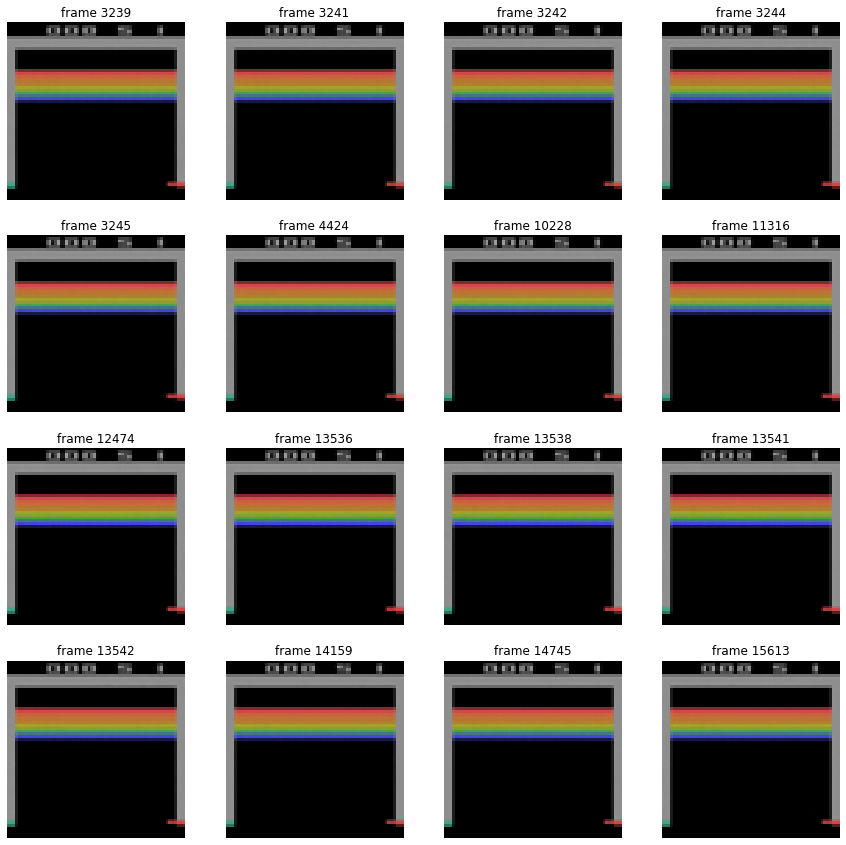

In [50]:
plt.figure(figsize=(15,15)) 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.title(f"frame {clu3_blue[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu3_blue[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')
    

lila links

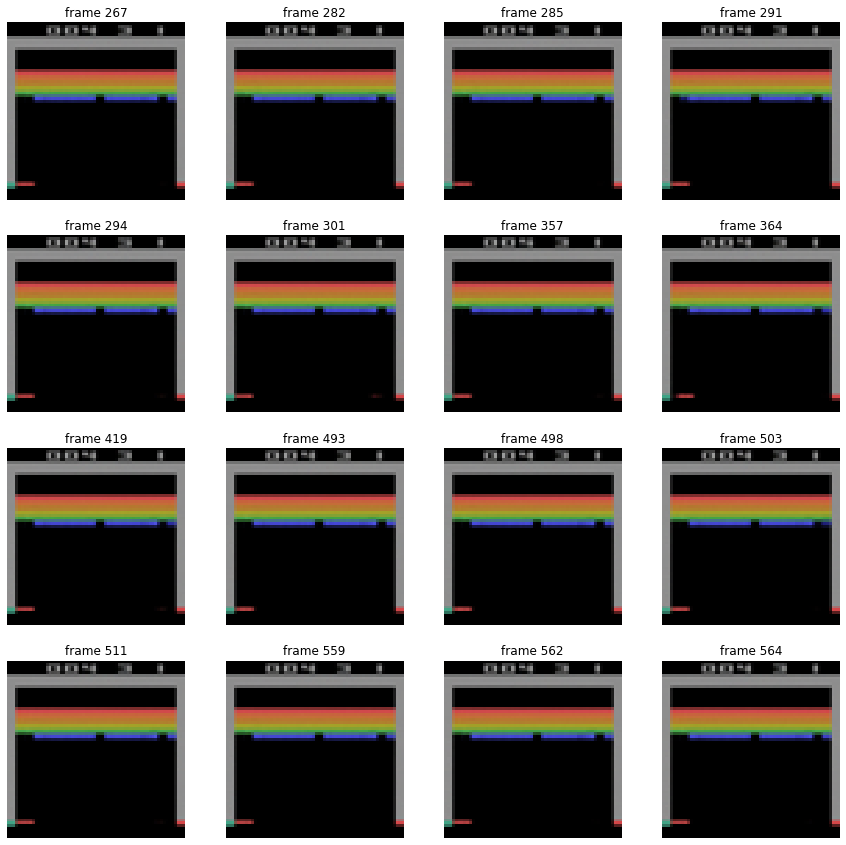

In [54]:
clu4 = np.where((y_tsne[:,0]>-21) & (y_tsne[:,0]<-19) & (y_tsne[:,1]<-9) & (y_tsne[:,1]>-11))[0].tolist()
len(clu4)

clu4_purp = [elem for elem in clu4 if actions[elem]==3]
len(clu4_purp)

plt.figure(figsize=(15,15)) 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.title(f"frame {clu4_purp[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu4_purp[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')
    

links unten lila

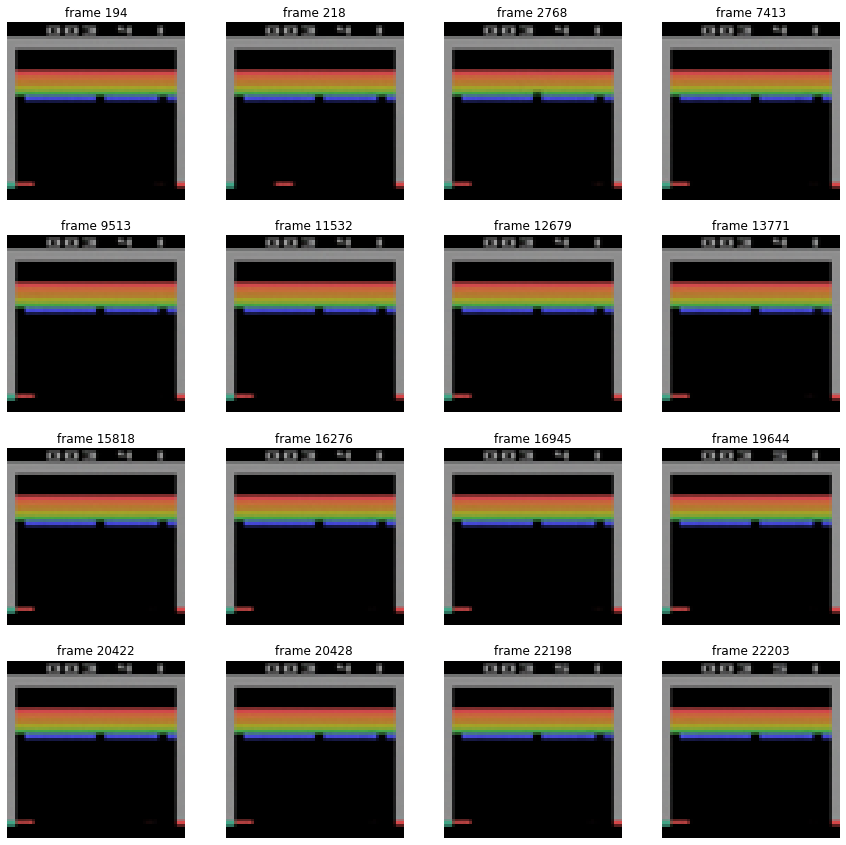

In [55]:
clu5 = np.where((y_tsne[:,0]>-19) & (y_tsne[:,0]<-18) & (y_tsne[:,1]<-27) & (y_tsne[:,1]>-28))[0].tolist()
len(clu5)

clu5_purp = [elem for elem in clu5 if actions[elem]==3]
len(clu5_purp)

plt.figure(figsize=(15,15)) 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.title(f"frame {clu5_purp[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu5_purp[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')
    

## TSNE - Target: Reward

In [56]:
reward_target = np.array(reward_target)

In [57]:
reward_target.shape

(63812,)

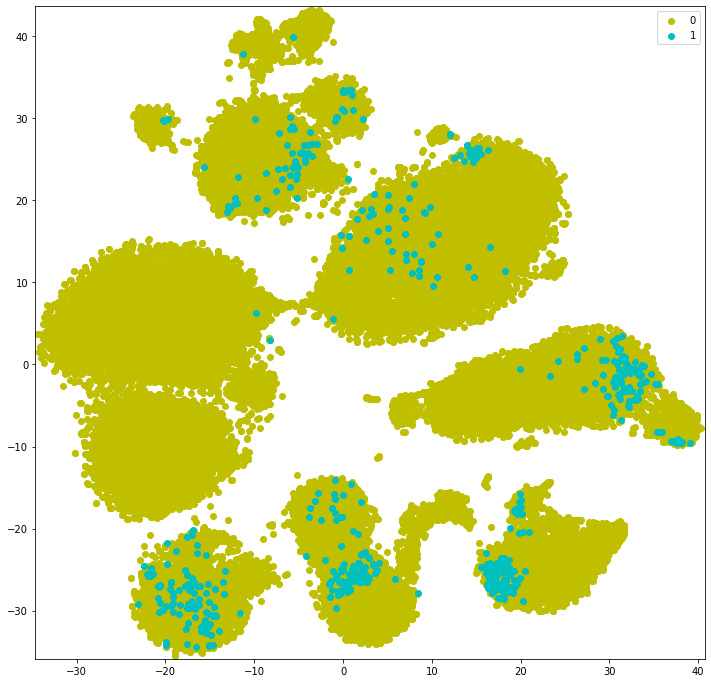

In [58]:
colors = 'y', 'c' # 
target_ids = range(2)


plt.figure(figsize=(12,12))
for i, c in zip(target_ids, colors):
    plt.scatter(y_tsne[reward_target==i, 0], y_tsne[reward_target==i, 1], c=c, label =i)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()